# Diebold Dataset Containing Fictitious Survey Data

The dataset by Diebold (n.d) comprised of a mix of ages, races, varying levels of self-advocacy training and self-efficacy along with the raises requested by individuals and whether they received a raise. In this analysis, the impact of self-efficacy on raise percentage requested and raise received among Hispanic and non-Hispanic female employees is determined.

Dataset Reference:
Diebold, C. (n.d.). Diebold Dataset and Codebook. Charles Diebold.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr

In [100]:
# read the csv file 
df = pd.read_csv('Diebold_Dataset.csv')
df.head()

,ID,Sex,Age,Hispanic_Origin,Race,political_party,valued_at_work,self_efficacy,Twenty4_7_365,political_skill,job,self_advocacy_workshop,intent_leave,RaiseRequest,got_last_raise,emp_sat,Efficacy_360
0,51,1.0,30.0,0.0,1.0,1.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,2.26,0.0,22.0,25.0
1,28,0.0,39.0,0.0,1.0,1.0,3.0,2.0,2.0,3.0,2.0,0.0,1.0,6.50,0.0,20.0,30.0
2,32,1.0,23.0,0.0,1.0,2.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,2.10,0.0,24.0,40.0
3,55,1.0,24.0,0.0,1.0,3.0,2.0,2.0,1.0,2.0,1.0,0.0,0.0,2.58,0.0,25.0,50.0
4,60,0.0,34.0,0.0,1.0,1.0,3.0,2.0,3.0,3.0,1.0,0.0,0.0,3.75,0.0,22.0,60.0


In [101]:
df = df[df["Sex"] == 1.0]  # Female participants were given encoding of 1 under Sex column

selected_features = ["Hispanic_Origin", "self_efficacy", "RaiseRequest", "got_last_raise"]

# Filter dataset on selected features 
df = df[selected_features]
df = df.dropna()

In [102]:
# Reassign Hispanic Origin to just "hispanic_ethnicity" using the true/false dichotomy and normalize variable names
df["Hispanic_Origin"] = df["Hispanic_Origin"].apply(lambda x: 1 if x > 0 else x)
df.rename(columns={
    "RaiseRequest": "raise_request",
    "got_last_raise": "raise_received",
    "Hispanic_Origin": "hispanic_ethnicity"
    }, inplace=True)
df.head()

,hispanic_ethnicity,self_efficacy,raise_request,raise_received
0,0.0,1.0,2.26,0.0
2,0.0,2.0,2.10,0.0
3,0.0,2.0,2.58,0.0
6,0.0,2.0,2.25,0.0
10,0.0,3.0,1.00,0.0


### Run Descriptive Analyses

/Users/erosado/work/text-and-convo-ai-ml-experiments/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


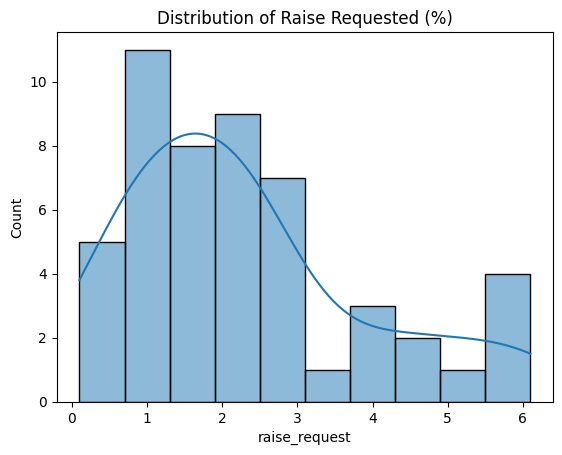

In [103]:
sns.histplot(df['raise_request'], bins=10, kde=True)
plt.title("Distribution of Raise Requested (%)")
plt.show()

/Users/erosado/work/text-and-convo-ai-ml-experiments/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


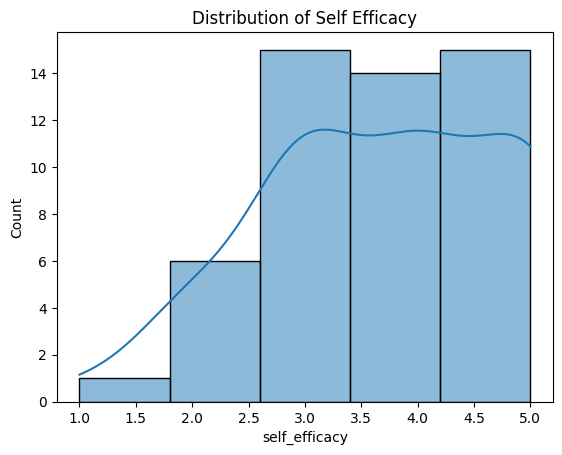

In [104]:
sns.histplot(df['self_efficacy'], bins=5, kde=True)
plt.title("Distribution of Self Efficacy")
plt.show()

In [105]:
def compute_frequencies(df, categorical_vars):
    """
    Computes frequency counts and percentages for categorical or binary variables.
    """
    results = {}

    for col in categorical_vars:
        freq_counts = df[col].value_counts()
        proportions = df[col].value_counts(normalize=True) * 100  # Convert to percentage

        results[col] = pd.DataFrame({
            "Category": freq_counts.index,
            "Frequency": freq_counts.values,
            "Percentage": proportions.values
        })

    return results

categorical_columns = ['hispanic_ethnicity', 'raise_received']
frequencies = compute_frequencies(df, categorical_columns)

for var, table in frequencies.items():
    print(f"\nVariable: {var}")
    print(table)


Variable: hispanic_ethnicity
   Category  Frequency  Percentage
0       0.0         41   80.392157
1       1.0         10   19.607843

Variable: raise_received
   Category  Frequency  Percentage
0       1.0         27   52.941176
1       0.0         24   47.058824


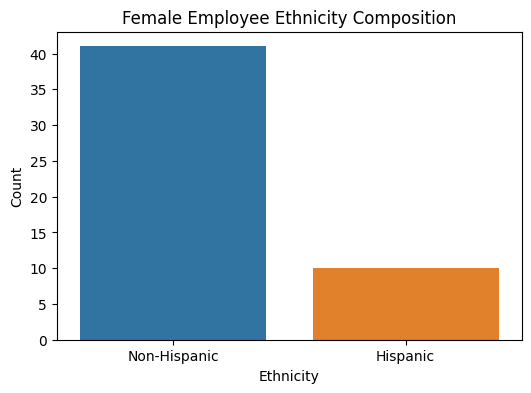

In [107]:
def plot_bar_chart(df, column, labels={0: "Non-Hispanic", 1: "Hispanic"}):
    """
    Creates a bar chart for a categorical variable.
    """
    df[column] = df[column].replace(labels)
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df[column])
    plt.xlabel("Ethnicity")
    plt.ylabel("Count")
    plt.title("Female Employee Ethnicity Composition")
    plt.show()

plot_bar_chart(df, 'hispanic_ethnicity')

In [108]:
def compute_central_tendencies_and_variance(df, continuous_vars):
    """
    Computes central tendency measures for continuous variables.
    """
    stats = {}
    for col in continuous_vars:
        stats[col] = {
            'Mean': np.mean(df[col]),
            'Median': np.median(df[col]),
            'Mode': df[col].mode().iloc[0] if not df[col].mode().empty else None,
            'Trimmed Mean (10%)': np.mean(df[col].sort_values().iloc[int(len(df[col]) * 0.1):-int(len(df[col]) * 0.1)]),
            'Standard Deviation': np.std(df[col], ddof=1),
            'Variance': np.var(df[col], ddof=1),
            'Range': df[col].max() - df[col].min(),
            'IQR (Interquartile Range)': np.percentile(df[col], 75) - np.percentile(df[col], 25)
        }
    
    return pd.DataFrame(stats).T

# Compute statistics for all variables
stats_df = compute_central_tendencies_and_variance(df, ["self_efficacy", "raise_request"])
print(stats_df)

                   Mean  Median  Mode  Trimmed Mean (10%)  Standard Deviation  \
self_efficacy  3.705882     4.0  3.00            3.780488            1.082481   
raise_request  2.284118     1.9  0.15            2.106098            1.608804   

               Variance  Range  IQR (Interquartile Range)  
self_efficacy  1.171765    4.0                      2.000  
raise_request  2.588249    6.0                      1.565  


The dataset has more non-Hispanic females than Hispanic. To mitigate the potential for statistical bias and issue with generalizability, Statistical Weighting will be used to ensure that the underrepresented group (Hispanic females) contributes equally to the analysis. The hispanic_ethnicity column has the dichotomy of interest (0 = Non-Hispanic, 1 = Hispanic).

### Run Inferencial Analyses

In [106]:
# Compute proportions
group_counts = df['hispanic_ethnicity'].value_counts(normalize=True)

# Compute inverse weights
df['weight'] = df['hispanic_ethnicity'].map(lambda x: 1 / group_counts[x])

df.head()

,hispanic_ethnicity,self_efficacy,raise_request,raise_received,weight
0,0.0,1.0,2.26,0.0,1.243902
2,0.0,2.0,2.10,0.0,1.243902
3,0.0,2.0,2.58,0.0,1.243902
6,0.0,2.0,2.25,0.0,1.243902
10,0.0,3.0,1.00,0.0,1.243902


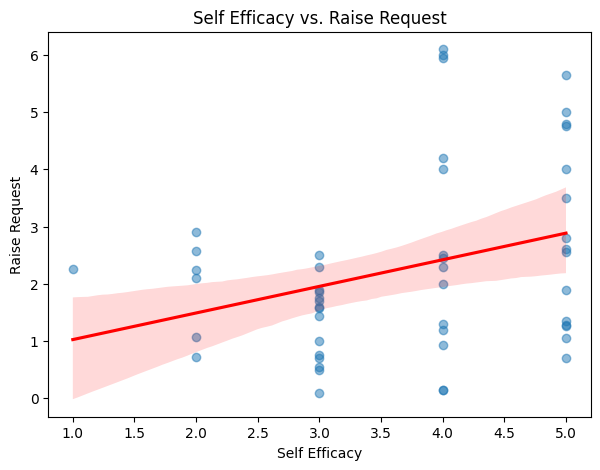

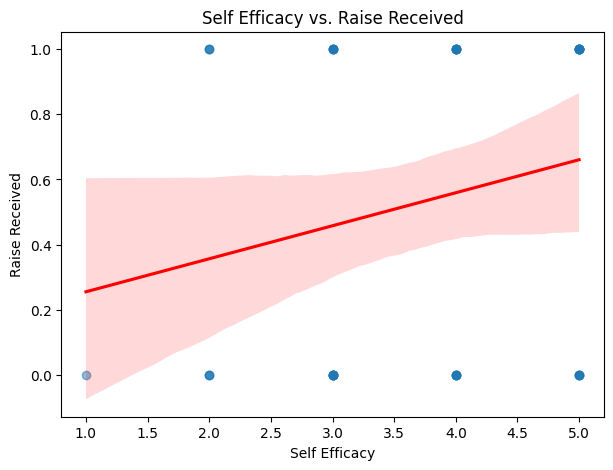

In [ ]:
def plot_scatter_with_trend(df, x, y):
    """
    Creates a scatter plot with a linear regression trend line.
    """
    plt.figure(figsize=(7, 5))
    sns.regplot(x=df[x], y=df[y], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
    plt.xlabel(x.replace("_", " ").title())
    plt.ylabel(y.replace("_", " ").title())
    plt.title(f"{x.replace('_', ' ').title()} vs. {y.replace('_', ' ').title()}")
    plt.show()


plot_scatter_with_trend(df, 'self_efficacy', 'raise_request')
plot_scatter_with_trend(df, 'self_efficacy', 'raise_received')

In [73]:

# Compute Pearson correlation since the relationship is linear
correlation, p_value = pearsonr(df['self_efficacy'], df['raise_request'])

print(f"Pearson Correlation (self-efficacy x raise requested): {correlation}, P-Value: {p_value}")

correlation, p_value = pearsonr(df['self_efficacy'], df['raise_received'])

print(f"\nPearson Correlation (self-efficacy x raise received): {correlation}, P-Value: {p_value}")

Pearson Correlation (self-efficacy x raise requested): 0.3129690683618638, P-Value: 0.025342528052971797

Pearson Correlation (self-efficacy x raise received): 0.2177533419342767, P-Value: 0.12478313178119065


In [75]:

def compute_correlation_by_group(df, group_col, x, y):
    """
    Computes Pearson correlation for a given independent and dependent variable,
    split by a categorical group.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    group_col (str): Column name of the categorical variable (e.g., 'ethnicity').
    x (str): Independent variable (e.g., 'self_efficacy').
    y (str): Dependent variable (e.g., 'raise_request').

    Returns:
    dict: Correlation coefficients and p-values for each group.
    """
    results = {}

    for group in df[group_col].unique():
        subset = df[df[group_col] == group]
        if len(subset) > 1:  # Ensure enough data points to compute correlation
            corr, p_value = pearsonr(subset[x], subset[y])
            results[group] = {"Correlation": corr, "p-value": p_value}
        else:
            results[group] = {"Correlation": None, "p-value": None}  # Not enough data

    return results

correlation_results = compute_correlation_by_group(
    df, 'hispanic_ethnicity', 'self_efficacy', 'raise_request'
    )
print("hispanic_ethnicity -> self_efficacy -> raise_request")
print(correlation_results)

correlation_results = compute_correlation_by_group(
    df, 'hispanic_ethnicity', 'self_efficacy', 'raise_received'
    )
print("\nhispanic_ethnicity -> self_efficacy -> raise_received")
print(correlation_results)

{'Non-Hispanic': {'Correlation': 0.24251420016980008, 'p-value': 0.1265784804519679}, 'Hispanic': {'Correlation': 0.5693677626430392, 'p-value': 0.08579787368640286}}
{'Non-Hispanic': {'Correlation': 0.17954308779539957, 'p-value': 0.2613351566403708}, 'Hispanic': {'Correlation': 0.040128617695256455, 'p-value': 0.9123598671021361}}


In [80]:
# re-encode the hispanic ethnicity
df['hispanic_ethnicity_enc'] = df['hispanic_ethnicity'].map({'Hispanic': 1, 'Non-Hispanic': 0})
df.head()

,hispanic_ethnicity,self_efficacy,raise_request,raise_received,weight,hispanic_ethnicity_enc
0,Non-Hispanic,1.0,2.26,0.0,1.243902,0
2,Non-Hispanic,2.0,2.10,0.0,1.243902,0
3,Non-Hispanic,2.0,2.58,0.0,1.243902,0
6,Non-Hispanic,2.0,2.25,0.0,1.243902,0
10,Non-Hispanic,3.0,1.00,0.0,1.243902,0


In [82]:
import pingouin as pg

# Run mediation analysis on hispanic_ethnicity -> self_efficacy -> raise_request
mediation_results = pg.mediation_analysis(
    data=df, x='hispanic_ethnicity_enc', m='self_efficacy', y='raise_request', n_boot=5000
)

print(mediation_results)

                path      coef        se      pval  CI[2.5%]  CI[97.5%]  sig
0  self_efficacy ~ X  0.490244  0.379244  0.202181 -0.271875   1.252363   No
1  Y ~ self_efficacy  0.465141  0.201651  0.025343  0.059908   0.870373  Yes
2              Total  0.854415  0.560022  0.133519 -0.270992   1.979821   No
3             Direct  0.647744  0.551447  0.245939 -0.461015   1.756503   No
4           Indirect  0.206671  0.167280  0.151200 -0.037564   0.639027   No


In [87]:
# Run mediation analysis on hispanic_ethnicity -> self_efficacy -> raise_received
mediation_results = pg.mediation_analysis(
    data=df, x='hispanic_ethnicity_enc', m='self_efficacy', y='raise_received', n_boot=5000
)

print(mediation_results)

                path      coef        se      pval  CI[2.5%]  CI[97.5%]  sig
0  self_efficacy ~ X  0.490244  0.379244  0.202181 -0.271875   1.252363   No
1  Y ~ self_efficacy  0.101406  0.064931  0.124783 -0.029078   0.231889   No
2              Total  0.460976  0.167087  0.008132  0.125201   0.796750  Yes
3             Direct  0.425287  0.169314  0.015428  0.084860   0.765715  Yes
4           Indirect  0.035688  0.044263  0.348400 -0.014678   0.172102   No


Using the results of the mediating analysis, self-efficacy does mediate the relationship of raise requested, just not for raise received. From the correlation analysis, we see a weak to moderate positive correlation between self-efficacy and raise requested but an insignificant weak positive correlation between self-efficacy and raise received. When the female subpopulation was split by Hispanic and non-Hispanic origins, neither variable pairing yielded a statistically significant positive relationship.

The analysis was limited as it only analyed female employees and did not account for the effect of self-advocacy training amongst individuals.